In [1]:
import model,utils
import local_datasets
from simulator.simulator import GaussianSimulator
from simulator.utils import load_params, load_coords_from_yaml
from simulator.init import init_probabilistically, init_from_cortex_full_view
from simulator.image_processing import sobel_processor, canny_processor, sample_receptive_fields, sample_centers

import torch
from torch.utils.data import DataLoader 

import numpy as np
from matplotlib import pyplot as plt

import cv2

(512,)


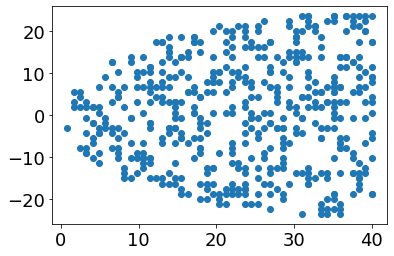

initialized 512 phosphenes, removed 0, 512 left
initialized 512 phosphenes, removed 0, 512 left


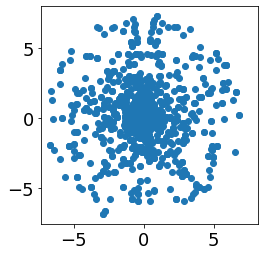

displaying 16 degrees of vision in a resolution of [256, 256]
one degree is 16.0 pixels
0 phosphenes are outside of view, will not be shown


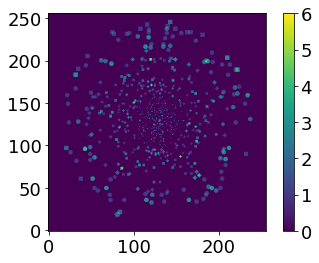

In [42]:
params = load_params('simulator/config/params.yaml')
electrode_coords = load_coords_from_yaml('simulator/config/grid_coords_dipole_valid.yaml',n_coords=512)

print(electrode_coords[0].shape)
plt.scatter(electrode_coords[0],electrode_coords[1])
plt.show()

# r, phi = init.init_probabilistically(params,n_phosphenes=1000)
r, phi = init_from_cortex_full_view(params, electrode_coords)    
# plt.scatter(electrode_coords[0],electrode_coords[1])
plt.scatter(r*np.cos(phi),r*np.sin(phi))
plt.axis('square')
plt.show()

simulator = GaussianSimulator(params, r, phi)
N_PHOSPHENES = simulator.n_phosphenes
gpu_nr = params['run']['gpu']
device = f'cuda:{int(gpu_nr)}' if gpu_nr else 'cpu'

RESOLUTION = params['run']['resolution']

im = plt.imshow(simulator.sampling_mask.sum(axis=0), origin='lower')
plt.colorbar(im)
plt.show()

In [26]:
simulator.reset()
FRAMERATE = params['run']['fps']
capture_nr = 46
cap = cv2.VideoCapture('simulator/clips/foreground_contours_thin.mp4')

if not cap.isOpened():
    print('Unable to read file :(')
    
fourcc = cv2.VideoWriter_fourcc(*'XVID') #codec
sim_resolution = simulator.resolution

# out = cv2.VideoWriter(save_path, fourcc, FRAMERATE, (sim_resolution[0]*2,sim_resolution[1]),False)
frame_nr = 0
ret, frame = cap.read()

while ret:
    ret, frame = cap.read()
    frame_nr+=1
    if ret:
        if frame_nr==capture_nr:
            # to one channel, grayscale 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # get square if frame is not square
            if frame.shape[0] != frame.shape[1]:
                shortest_side = min(frame.shape)
                frame = frame[frame.shape[0]//2-shortest_side//2:frame.shape[0]//2+shortest_side//2,frame.shape[1]//2-shortest_side//2:frame.shape[1]//2+shortest_side//2]
                
            # preprocess: to resize, grayscale and blur
            frame = cv2.resize(frame, sim_resolution)
            frame = cv2.GaussianBlur(frame, (3,3), 0)

            if params['sampling']['filter'] == 'sobel':
                processed_img = sobel_processor(frame)
            elif params['sampling']['filter'] == 'canny':
                processed_img = canny_processor(frame,params['sampling']['T_high']//2,params['sampling']['T_high'])
            elif params['sampling']['filter'] == 'none':
                processed_img = frame
            else:
                raise ValueError(f"{params['sampling']['filter']} is not a valid filter keyword")
                
            # Generate phosphenes 
            if params['sampling']['sampling_method'] == 'receptive_fields': 
                stim_pattern = sample_receptive_fields(processed_img, simulator.sampling_mask)
            elif params['sampling']['sampling_method'] == 'center':
                stim_pattern = sample_centers(processed_img, simulator.pMap)
            else:
                raise ValueError(f"{params['sampling']['sampling_method']} is not a valid sampling method")

            stim_pattern = stim_pattern.view(1,-1).to(device)

            # Generate phosphenes 
            phs = simulator(stim_pattern).clamp(0,1)
            phs = phs.squeeze().cpu().numpy()*255

            break

    else:
        break
    # the 'q' button is set as the quit button

cap.release()

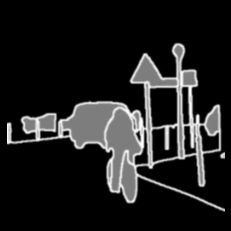

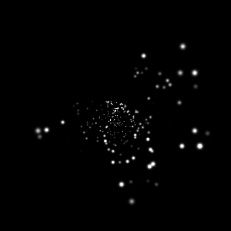

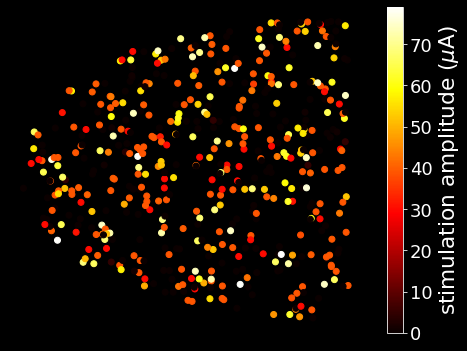

In [43]:
plt.rcParams.update({
    'axes.labelsize': 'large',
    'font.size': 18,
    'lines.linewidth': 2.5})
plt.style.use('dark_background')

plt.imshow(processed_img,cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(phs,cmap='gray')
plt.axis('off')
plt.show()
stim_map = stim_pattern.squeeze().cpu().numpy()#.reshape((32,32))
# plt.imshow(stim_map)
# plt.colorbar()
# plt.show()
fig = plt.figure(figsize=(8,6))
plt.scatter(electrode_coords[0],electrode_coords[1],c=stim_map[:512]*1e6,cmap='hot')
cbar = plt.colorbar()
cbar.set_label('stimulation amplitude ($\mu$A)')
plt.axis('off')
plt.show()

In [2]:
trainset = local_datasets.Character_Dataset(device='cpu', directory='./datasets/Characters',invert=False)
trainloader = DataLoader(trainset,batch_size=int(1),shuffle=True)

In [3]:
encoder = model.E2E_Encoder(in_channels=1, binary_stimulation=True).to('cpu')

params = load_params('simulator/config/params.yaml')
r, phi = init_probabilistically(params,n_phosphenes=1024)
realistic_simulator = model.E2E_RealisticPhospheneSimulator(params, r, phi)#.to(cfg.device)

TypeError: __init__() missing 1 required positional argument: 'phi'

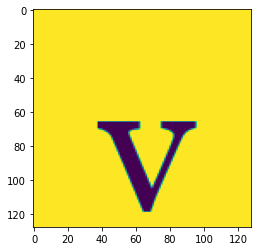

In [4]:
image, label = next(iter(trainloader))

plt.imshow(image[0][0])

In [9]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    x = torch.arange(h)
    Y, X = torch.meshgrid(x,x)
    dist_from_center = torch.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask



/home/maureen/anaconda3/envs/thesis_env/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


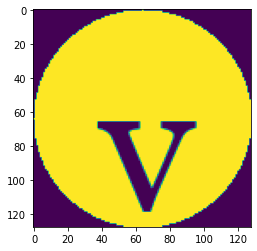

In [10]:
mask = create_circular_mask(image[0][0].shape[0],image[0][0].shape[1])
plt.imshow(image[0][0]*mask)

In [5]:
stim = encoder(image)
proxy = 1e-6*torch.ones_like(stim,device='cpu')
img = realistic_simulator(proxy).cpu().numpy()

62 out of 1 cross threshold
charge per second::
        size:   torch.Size([1, 1024])
        min:    5.10E-08
        max:    5.10E-08
        mean:   5.10E-08
        std:    3.55E-15
sigma (in pixels):
        size:   torch.Size([1, 1024])
        min:    2.14E-02
        max:    3.06E-01
        mean:   1.12E-01
        std:    7.99E-02
activation:
        size:   torch.Size([1, 1024])
        min:    5.10E-08
        max:    5.10E-08
        mean:   5.10E-08
        std:    3.55E-15
sigmoided activation:
        size:   torch.Size([1, 1024])
        min:    0.00E+00
        max:    4.08E-03
        mean:   2.47E-04
        std:    9.73E-04


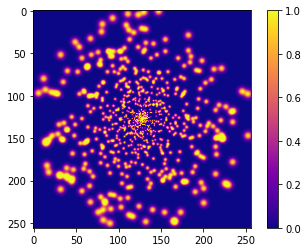

In [18]:
plt.imshow(img[0][0],cmap='plasma')
plt.colorbar()